# Disclaimer
The entire notebook is taken from the following link:<br>
https://www.kaggle.com/gabtre/nyc-taxi-made-simple-msrle-0-42/notebook <br>


Except that the part starting with INF 552 is original.<br>
The reason I borrow the code is to prove that the algorithm purposed by the project can be used to <br>
improve the results of others'.<br>

In [213]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt # to handle dates and time
from datetime import datetime, timedelta, date

from functools import reduce

# data visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#import cufflinks as cf
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
def get_csv_cluster(filename,pred_y,testid):
    #print(pred_y.shape)
    duration_content = np.rint(pred_y)
    #duration_content = np.array(duration_content)
    #print(duration_content.shape)
    
    #print(duration_content)
    id_content = np.array(testid)
    #print(id_content.shape)

    df = pd.DataFrame({
        'id':id_content,
        'trip_duration':duration_content
    })

    # Create the csv file
    fn = filename + '.csv'
    df.to_csv(fn,index= False)
    

In [214]:
# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import Imputer, OneHotEncoder, LabelBinarizer, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

 ## Custom Functions

In [215]:
def mean_cross_score(x):
    print("Accuracy: %0.3f +/- %0.3f" % (np.mean(x), np.std(x)))

In [216]:
class DataFrameSelector(BaseEstimator, TransformerMixin): # to select dataframes in a pipeline.
    def __init__(self, attributes): 
        self.attributes = attributes
    def fit(self, df, y=None): 
        return self
    def transform(self, df):
        return df[self.attributes].values

In [217]:
def RemoveOutliers(df,cols,n_sigma): # keep only instances that are within p\m n_sigma in columns cols
    new_df = df.copy()
    for col in cols:
        new_df = new_df[np.abs(new_df[col]-new_df[col].mean())<=(n_sigma*new_df[col].std())]
    print('%i instances have been removed' %(df.shape[0]-new_df.shape[0]))
    return new_df

In [218]:
def my_pipeline(df, func_list):
    new_df = df.copy()
    return reduce(lambda x, func: func(x), func_list, new_df)

## Loading Data

In [219]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

holidays_df = pd.read_csv('NYC_2016Holidays.csv', sep=';')

In [220]:
# Geo locations taken from Google maps
NYC = np.array([-74.0059,40.7128]) # google maps coordinates of NYC

fifth_ave = np.array([0.58926996811979,0.8079362008674332]) # versor of Fifth Av. digitized from google maps
ort_fifth_ave = np.array([-0.8079362008674332,0.58926996811979]) # orthogonal versor

EastRiver = np.array([-73.955921,40.755157])
HudsonRiver = np.array([-74.012226,40.755677])
LeftBound = np.array([-74.020485,40.701463])
RightBound = np.array([-73.932614,40.818593])

## Initial Exploration of the Data

In [221]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


There are 1.5 millions instances in this dataset, which means it is fairly big. Notice also that there are no *null* values in the training set. Given the size of this set I think it is fair to assume that also the test set won't have any null value, but you never know...

The labels are pretty much self explenatory, so we want go into details. 

Notice also that there are 4 objects that need to be transformed for ML purposes:
- **id**: this will probably be useless
- **pickup_datetime** and **dropoff_datetime**: this can be transformed in with the *datetime* library
- **store_and_fwd_flag**: this attribute flags whether the instance was uploaded immidiately or not. I don't know if it will be usefull or not...

Lets do some consistency check on the train set

In [222]:
train_df['id'].value_counts().shape

(1458644,)

This matches the total number if instances, so each instance is unique.

What about the **store_and_fwd_flag**?

In [223]:
train_df['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

There are just 8000 instances flagged 'Yes' out of 1.5 millions. This suggests that this attribute will probably be useless for our ML. However, we should check whether this instances are peculiar in some respect.  

In [224]:
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Lets take a better look at the **vendor_id** and **passenger_count** attributes:

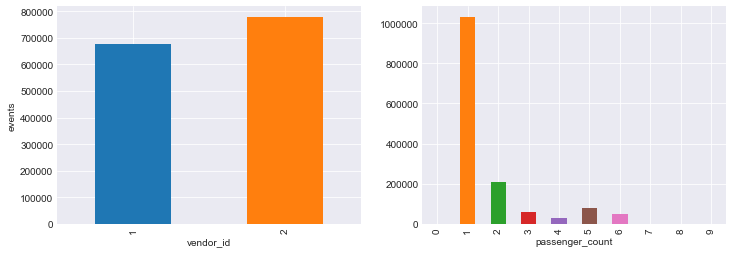

In [225]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
data = train_df['vendor_id'].value_counts().sort_index()
data.plot(kind='bar')
plt.xlabel('vendor_id')
plt.ylabel('events')

plt.subplot(1,2,2)
data = train_df['passenger_count'].value_counts().sort_index()
data.plot(kind='bar')
plt.xlabel('passenger_count')

plt.show()

Notice that *value_counts()* givs only the non-null values... so apparently there were rides with zero passengers!
Lets keep in mind this when we exclude outliers.

This is probably going to be one of the most eye catching plots. Lets look at the pickup location:

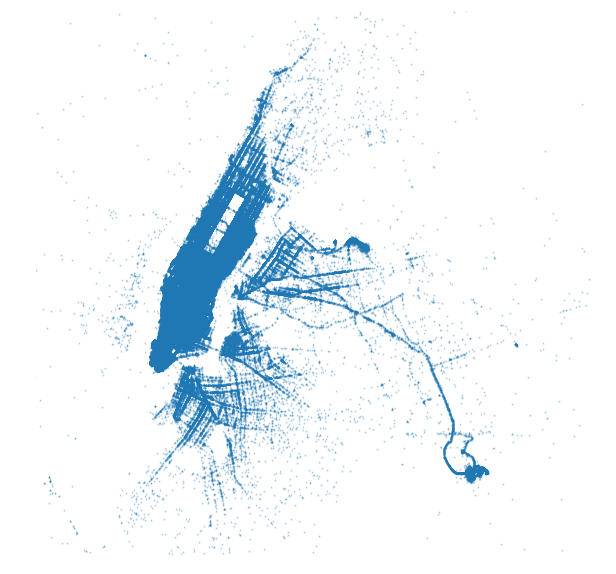

In [226]:
plt.figure(figsize=(10,10))

plt.scatter(x=train_df['pickup_longitude'].values,y=train_df['pickup_latitude'].values, marker='^',s=1,alpha=.3)
plt.xlim([-74.1,-73.7])
plt.ylim([40.6, 40.9])
plt.axis('off')

#plt.scatter(x=train_df['dropoff_longitude'].values,y=train_df['dropoff_latitude'].values, marker='v',s=1,alpha=.1)
#plt.xlim([-74.05,-73.75])
#plt.ylim([40.6, 40.9])
#plt.axis('off')

plt.show()

One million rides... 

Even without a map beneath one can recognize Manhattan, Brooklyn and the airports JFK and La Guardia!
In fact, from this plot one already can see that most of the rides happen in Manhatthan. We'll check this quantitatively later. 

There are also some weird instances of cabs going into the ocean! and a couple of NY cabs in SF! outliers...
We could remove them more carefully later, but instead lets just remove the 3 $\sigma$ tails.

In [227]:
clean_att = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
train_df_clean = RemoveOutliers(train_df,clean_att,5)

14344 instances have been removed


Next we have **trip_duration**, that is what we have to predict. Notice that the competition calculates the MSR Log Error. So we can directly take the log of **trip_duration**.

In [228]:
train_df_clean['trip_duration'] = np.log(train_df_clean['trip_duration'])

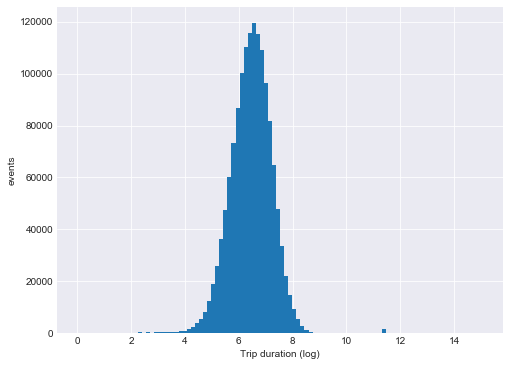

In [229]:
plt.figure(figsize=(8,6))

plt.hist(train_df_clean['trip_duration'], bins=100)
#plt.yscale('log', nonposy='clip')
plt.xlabel('Trip duration (log)')
plt.ylabel('events')

plt.show()

The duration is a nice bell-shaped distribution in log space, however there is some small peak around log(duration)=11. Lets clean a bit more the data by removing the outliers

In [230]:
clean_att = ['trip_duration']
train_df_clean = RemoveOutliers(train_df_clean,clean_att,5)

4148 instances have been removed


This is the result after cleaning

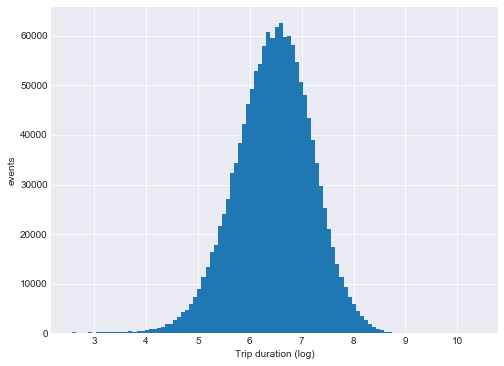

In [231]:
plt.figure(figsize=(8,6))

plt.hist(train_df_clean['trip_duration'], bins=100)
#plt.yscale('log', nonposy='clip')
plt.xlabel('Trip duration (log)')
plt.ylabel('events')

plt.show()

## Data Preparation for ML

Most ML algorithm and sklearn class works with numberical attributes only, so we need to transform the object-type attributes.
Lets create a list of numerical and categorical attributes

In [232]:
num_att = [f for f in train_df_clean.columns if train_df_clean.dtypes[f] != 'object']
cat_att = [f for f in train_df_clean.columns if train_df_clean.dtypes[f] == 'object']
print("-"*10+" numerical attributes "+"-"*10)
print(num_att)
print('')
print("-"*10+" categorical attributes "+"-"*10)
print(cat_att)

---------- numerical attributes ----------
['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']

---------- categorical attributes ----------
['id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag']


### Trip Duration

First lets run a consistency check on the data

In [233]:
train_df_clean['pickup_datetime'] = pd.to_datetime(train_df_clean['pickup_datetime'])
train_df_clean['dropoff_datetime'] = pd.to_datetime(train_df_clean['dropoff_datetime'])

delta_t = np.log((train_df_clean['dropoff_datetime']-train_df_clean['pickup_datetime']).dt.total_seconds())
print("Number of wrong trip durations: %i" %train_df_clean[np.round(delta_t,5)!=np.round(train_df_clean['trip_duration'],5)].shape[0])

Number of wrong trip durations: 0


The train_set is consitent, so we can drop the dropoff time and split the dataframes in X (the features) and Y (what we have to predict)

In [234]:
X_train = train_df_clean.drop(['id','dropoff_datetime','trip_duration'], axis=1)
Y_train = train_df_clean['trip_duration'].copy()

X_test = test_df.drop(['id'], axis=1)
X_test_id = test_df['id'].copy()


cat_att = ['store_and_fwd_flag']
date_att = ['pickup_datetime']
coord_att = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

### Categorical attributes

In [235]:
def FlagEncoder(df):
    new_df = df.copy()
    new_df['store_and_fwd_flag'] = (new_df['store_and_fwd_flag']=='Y')*1
    return new_df

### Datetime Attributes

Here we'll use the holidays dataset to add a 'weekend' attribute. We'll also transform the pick_datetime into 'day' (i.e. the day of the week) and 'time' (the time of the pickup).

In [236]:
holidays = (pd.to_datetime('2016 '+ holidays_df['Date']))

In [237]:
def DateAttributes(df):
    new_df = df.copy()
    new_df['pickup_datetime'] = pd.to_datetime(new_df['pickup_datetime'])
    new_df['day'] = new_df['pickup_datetime'].dt.weekday
    new_df['weekend'] = 1*((new_df['day']>=5)|(new_df['pickup_datetime'].dt.date.isin(holidays.dt.date.values)))
    new_df['time'] = np.round(new_df['pickup_datetime'].dt.time.apply(lambda x: x.hour + x.minute/60.0),1)
    return new_df

### Numerical Attributes

#### Distance

From Physics 101, distance = speed * time, so we should try to find the distance and the speed of each ride to help the ML algorith. This is probably the most difficult part of the game.

We will define two kind of distances called L1 and L2. The L1 distance is the typical distance you experience in Mahatthan going from point A to point B. The L2 distance is just the Euclidean distance. 

I've seen many people using very complex definition of distances on this competition, for example the Haversine distance. This is the distance on a a great circle from a point A on a sphere of radius R to another point B. I think this is quite an overdoing. The size of NYC compared to the radius of the Earth is minuscle. so the error that one makes in treating the Earth as flat is more that acceptable. 

So the easy option is just to use longitude and latitude as coordinates on a plane! No Haversine needed! We only have to express latitude and longitude with the same (arbitrary) unit of measurement. In fact, I've already used this approximation in the plot above. 

In [238]:
def distance(coords): #  L1 and L2 distances (in arbitrary units)
    units = np.array([np.cos(np.radians(NYC[1])),1]) # multiply by 111.2 to get km 
    picks = np.split(coords.transpose(),2)[0].transpose()*units
    drops = np.split(coords.transpose(),2)[1].transpose()*units
    x1 = np.dot(picks,fifth_ave*units)
    y1 = np.dot(picks,ort_fifth_ave*units)    
    x2 = np.dot(drops,fifth_ave*units)
    y2 = np.dot(drops,ort_fifth_ave*units)
    dist_L1 = abs(x1-x2) + abs(y1-y2)
    dist_L2 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return [dist_L1,dist_L2]

In [239]:
def DistanceAttribute(df):
    new_df = df.copy()
    coords = new_df[coord_att].values
    new_df['dist_L1'] = distance(coords)[0]
    new_df['dist_L2'] = distance(coords)[1]
    return new_df

In [240]:
# Adding attributes
pipe_list = [FlagEncoder, DateAttributes, DistanceAttribute]

X_train_prepared = my_pipeline(X_train,pipe_list)
X_test_prepared = my_pipeline(X_test,pipe_list)

But how many rides actually happen within Manhattan?

To answer this question one could use a clustering algorith. but we'll make it simpler here: we'll just define a strip on the map and call it Manhattan. Here it is:

In [241]:
X=X_train_prepared

c1 = (X['pickup_longitude']>LeftBound[0])&(X['pickup_longitude']<RightBound[0])
c2 = (X['pickup_longitude']>LeftBound[0])&(X['dropoff_longitude']<RightBound[0])
c3 = ((X['pickup_longitude']-EastRiver[0])*ort_fifth_ave[0]+(X['pickup_latitude']-EastRiver[1])*ort_fifth_ave[1])>0
c4 = ((X['pickup_longitude']-HudsonRiver[0])*ort_fifth_ave[0]+(X['pickup_latitude']-HudsonRiver[1])*ort_fifth_ave[1])<0
c5 = ((X['dropoff_longitude']-EastRiver[0])*ort_fifth_ave[0]+(X['dropoff_latitude']-EastRiver[1])*ort_fifth_ave[1])>0
c6 = ((X['dropoff_longitude']-HudsonRiver[0])*ort_fifth_ave[0]+(X['dropoff_latitude']-HudsonRiver[1])*ort_fifth_ave[1])<0

Manhattan_df = X[c1&c2&c3&c4&c5&c6]
Y_Manhattan = Y_train.values[c1&c2&c3&c4&c5&c6]
print('Percentage of trips within Manhattan: %.2f' %(1.*Manhattan_df.shape[0]/X.shape[0])) 

Percentage of trips within Manhattan: 0.85


Almost all rides are within Manhattan! The L1 distance will be a quite accurate estimate of the true distance for these instances. 

What about JFK and La Guardia?

In [242]:
JFK = np.array([-73.779148,40.653416])
LaGuardia = np.array([-73.873890,40.775341])

In [243]:
X=X_train_prepared

c1 = (X['pickup_longitude']>(JFK[0]-0.05))&(X['pickup_longitude']<(JFK[0]+0.05))
c2 = (X['pickup_latitude']>(JFK[1]-0.05))&(X['pickup_latitude']<(JFK[1]+0.05))
c3 = (X['dropoff_longitude']>(JFK[0]-0.05))&(X['dropoff_longitude']<(JFK[0]+0.05))
c4 = (X['dropoff_latitude']>(JFK[1]-0.05))&(X['dropoff_latitude']<(JFK[1]+0.05))

JFK_df = X[(c1&c2)|(c3&c4)]
Y_JFK = Y_train.values[(c1&c2)|(c3&c4)]
print('Percentage of trips to/from JFK: %.2f' %(1.*JFK_df.shape[0]/X.shape[0])) 

Percentage of trips to/from JFK: 0.02


In [244]:
X=X_train_prepared

c1 = (X['pickup_longitude']>(LaGuardia[0]-0.02))&(X['pickup_longitude']<(LaGuardia[0]+0.02))
c2 = (X['pickup_latitude']>(LaGuardia[1]-0.02))&(X['pickup_latitude']<(LaGuardia[1]+0.02))
c3 = (X['dropoff_longitude']>(LaGuardia[0]-0.02))&(X['dropoff_longitude']<(LaGuardia[0]+0.02))
c4 = (X['dropoff_latitude']>(LaGuardia[1]-0.02))&(X['dropoff_latitude']<(LaGuardia[1]+0.02))

LaGuardia_df = X[(c1&c2)|(c3&c4)]
Y_LaGuardia = Y_train.values[(c1&c2)|(c3&c4)]
print('Percentage of trips to/from La Guardia: %.2f' %(1.*LaGuardia_df.shape[0]/X.shape[0])) 

Percentage of trips to/from La Guardia: 0.04


That is interesting La Guardia as twice as many rides as JFK, but from [this link](http://http://laguardiaairport.com/about-us/facts-and-statistics/) and [this link](http://https://www.panynj.gov/airports/pdf/stats/JFK_DEC_20016.pdf), JFK has twice as many passengers as La Guardia. SO people going to La Guardia are more inclined to take a Taxi... if you have been to La Guardia you know what I'm talking about.

In [245]:
# Dataframe consolidation
Manhattan_df = DistanceAttribute(Manhattan_df)
JFK_df = DistanceAttribute(JFK_df)
LaGuardia_df = DistanceAttribute(LaGuardia_df)

Lets now look at how well the distance attribute predict the trip duration. A scatter plot is a good starting point.

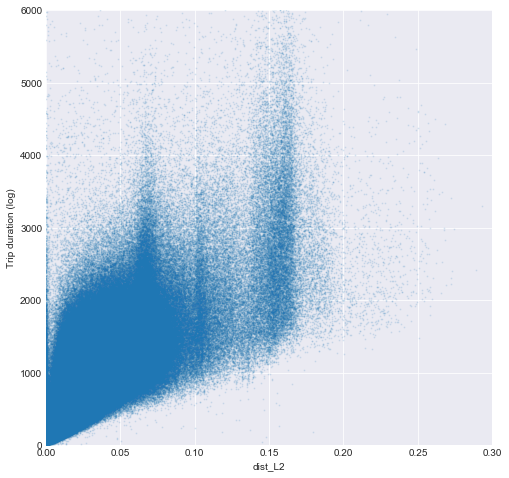

In [246]:
plt.figure(figsize=(8,8))

plt.scatter(x=X_train_prepared['dist_L2'].values,y=np.exp(Y_train).values,s=1,alpha=0.1)
plt.xlim([0,0.3])
plt.ylim([0, 6000])
#plt.axis('off')
plt.xlabel('dist_L2')
plt.ylabel('Trip duration (log)')

plt.show()

This is another interesting plot. One can see a bulk of instances with large scatter at distance L2 less than 0.1, and then 3 clear spikes: one at 0 distance (outliers?), one at 0.12 and one at 0.22. Notice that a spike in the distance means a fixed prefered length of travelling... I already know where people is going!

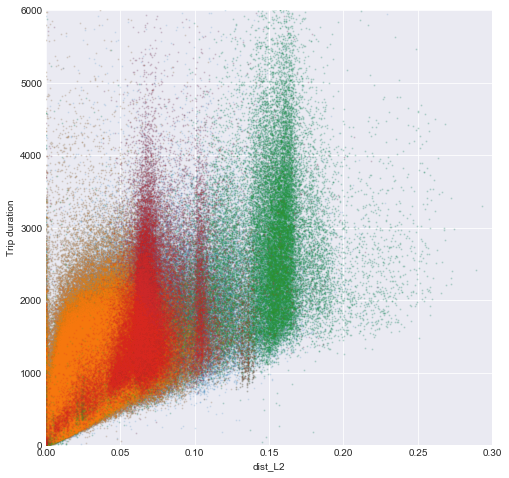

In [247]:
plt.figure(figsize=(8,8))

plt.scatter(x=X_train_prepared['dist_L2'].values,y=np.exp(Y_train),s=1,alpha=0.1)
plt.scatter(x=Manhattan_df['dist_L2'].values,y=np.exp(Y_Manhattan),s=1,alpha=0.1)
plt.scatter(x=JFK_df['dist_L2'].values,y=np.exp(Y_JFK),s=1,alpha=0.1)
plt.scatter(x=LaGuardia_df['dist_L2'].values,y=np.exp(Y_LaGuardia),s=1,alpha=0.1)

plt.xlim([0,0.3])
plt.ylim([0, 6000])
plt.xlabel('dist_L2')
plt.ylabel('Trip duration')

plt.show()

The data divides well in three clusters: rides within Manhattan and rides to/from the airport. This make around the 90% of the data. so lets define new attribute with this information encoded a la OneHot. Furthermore lets clean the spike at zero distance.

In [248]:
c1 = X_train_prepared['dist_L1']>0.0001
c2 = X_train_prepared['dist_L2']>0.0001

X_train = X_train[(c1&c2)]
Y_train = Y_train[c1&c2]

In [249]:
def RideScope(df):
    X = df.copy()
    
    # Manhatthan only
    c1 = (X['pickup_longitude']>LeftBound[0])&(X['pickup_longitude']<RightBound[0])
    c2 = (X['dropoff_longitude']>LeftBound[0])&(X['dropoff_longitude']<RightBound[0])
    c3 = ((X['pickup_longitude']-EastRiver[0])*ort_fifth_ave[0]+(X['pickup_latitude']-EastRiver[1])*ort_fifth_ave[1])>0
    c4 = ((X['pickup_longitude']-HudsonRiver[0])*ort_fifth_ave[0]+(X['pickup_latitude']-HudsonRiver[1])*ort_fifth_ave[1])<0
    c5 = ((X['dropoff_longitude']-EastRiver[0])*ort_fifth_ave[0]+(X['dropoff_latitude']-EastRiver[1])*ort_fifth_ave[1])>0
    c6 = ((X['dropoff_longitude']-HudsonRiver[0])*ort_fifth_ave[0]+(X['dropoff_latitude']-HudsonRiver[1])*ort_fifth_ave[1])<0

    X['M&M'] = (c1&c2&c3&c4&c5&c6)*1
    
    # JFK
    c1 = (X['pickup_longitude']>(JFK[0]-0.05))&(X['pickup_longitude']<(JFK[0]+0.05))
    c2 = (X['pickup_latitude']>(JFK[1]-0.05))&(X['pickup_latitude']<(JFK[1]+0.05))
    c3 = (X['dropoff_longitude']>(JFK[0]-0.05))&(X['dropoff_longitude']<(JFK[0]+0.05))
    c4 = (X['dropoff_latitude']>(JFK[1]-0.05))&(X['dropoff_latitude']<(JFK[1]+0.05))
    
    X['JFK'] = ((c1&c2)|(c3&c4))*1
    
    #LaGuardia
    c1 = (X['pickup_longitude']>(LaGuardia[0]-0.02))&(X['pickup_longitude']<(LaGuardia[0]+0.02))
    c2 = (X['pickup_latitude']>(LaGuardia[1]-0.02))&(X['pickup_latitude']<(LaGuardia[1]+0.02))
    c3 = (X['dropoff_longitude']>(LaGuardia[0]-0.02))&(X['dropoff_longitude']<(LaGuardia[0]+0.02))
    c4 = (X['dropoff_latitude']>(LaGuardia[1]-0.02))&(X['dropoff_latitude']<(LaGuardia[1]+0.02))

    X['LaG'] = ((c1&c2)|(c3&c4))*1
    
    return X

In [250]:
pipe_list = pipe_list + [RideScope]

X_train_prepared = my_pipeline(X_train,pipe_list)
X_test_prepared = my_pipeline(X_test,pipe_list)

Everybody knows that a ride from JFK is unpredictable, but can we understand the dispersion better? It surely depends on the traffic along the way, which is probably correlated with the time of the pickup. Lets check.

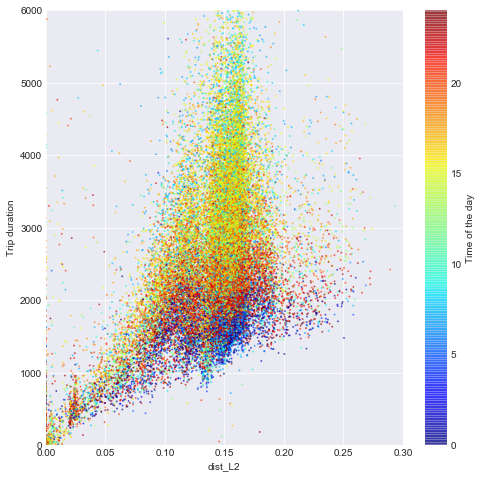

In [251]:
plt.figure(figsize=(8,8))

sc = plt.scatter(JFK_df['dist_L2'].values,np.exp(Y_JFK),c=JFK_df['time'],s=1,cmap=plt.get_cmap('jet'),alpha=0.5)
plt.xlim([0,0.3])
plt.ylim([0, 6000])
cb = plt.colorbar(sc)
plt.xlabel('dist_L2')
plt.ylabel('Trip duration')
cb.set_label('Time of the day')

plt.show()

As expected, trips that start at night have much less scatter than trips that happen during the day. So better to include the time in the attribute for ML. 

#### Speed

The previous plot suggesed that the time of the day is (obviously) important. So lets take a look at the average speed of each ride vs the time of the day

In [252]:
def Speeds(df,Y):
    new_df = df.copy()
    new_df['speed_L1'] = new_df['dist_L1']/np.exp(Y)
    new_df['speed_L2'] = new_df['dist_L2']/np.exp(Y)
    return new_df

In [253]:
speed_df = Speeds(X_train_prepared,Y_train)

weekday_speed = speed_df.groupby(['weekend','time']).agg(['mean','std'])[['speed_L1','speed_L2']].loc[0].reset_index()
weekend_speed = speed_df.groupby(['weekend','time']).agg(['mean','std'])[['speed_L1','speed_L2']].loc[1].reset_index()

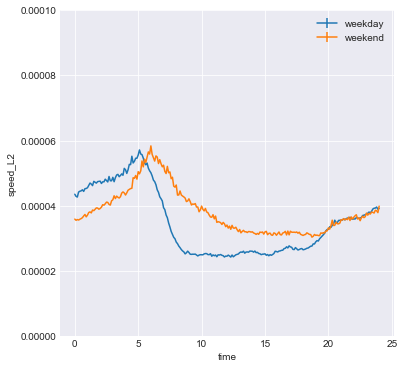

In [254]:
plt.figure(figsize=(6,6))

plt.errorbar(weekday_speed['time'],weekday_speed['speed_L2']['mean'],yerr=0, label='weekday')
plt.errorbar(weekend_speed['time'],weekend_speed['speed_L2']['mean'],yerr=0, label='weekend')
plt.ylim([0, 0.000125])

#plt.errorbar(weekday_speed['time'],weekday_speed['speed_L2']['mean'],yerr=weekday_speed['speed_L2']['std'])
#plt.errorbar(weekend_speed['time'],weekend_speed['speed_L2']['mean'],yerr=weekend_speed['speed_L2']['std'])
#plt.ylim([0, 0.000125])
plt.ylim([0, 0.0001])
plt.xlabel('time')
plt.ylabel('speed_L2')
plt.legend()

plt.show()

Notice the speed plateau during 9 -19 of weekdays and the lower speed at night during weekend.

We can define a speed attribute (actually two, wrt L1 and L2) only on the train set, since there is no known duration on the test. Therfore we need a rule to define it also for the test set. 'time' and 'weekend' seems to obvious selection rules.

In [255]:
speeds = speed_df.groupby(['weekend','time']).mean()[['speed_L1','speed_L2']].reset_index()

In [256]:
def SpeedAttribute(df):
    new_df = df.copy()
    new_df = pd.merge(new_df, speeds, how='left', on=['weekend','time'])
    return new_df

In [257]:
pipe_list = pipe_list + [SpeedAttribute]

X_train_prepared = my_pipeline(X_train,pipe_list)
X_test_prepared = my_pipeline(X_test,pipe_list)

## Attributes selection and scaling

In [258]:
X_train_prepared.columns

Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'day', 'weekend', 'time', 'dist_L1', 'dist_L2',
       'M&M', 'JFK', 'LaG', 'speed_L1', 'speed_L2'],
      dtype='object')

In [259]:
num_att = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','dist_L1','dist_L2','speed_L1','speed_L2','time']
OneHot = ['weekend','M&M','JFK','LaG']

In [260]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_att)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

OneHot_pipeline = Pipeline([
    ('selector', DataFrameSelector(OneHot)),
])

In [261]:
full_pipeline = FeatureUnion(transformer_list=[
           ("num_pipeline", num_pipeline),
           ("cat_pipeline", OneHot_pipeline),
])

In [262]:
X_train_scaled = full_pipeline.fit_transform(X_train_prepared)
X_test_scaled = full_pipeline.transform(X_test_prepared)

## Model Selection and Training

In [263]:
my_x = X_train_scaled.copy()
my_y = Y_train.copy()
my_test = X_test_scaled.copy()

In [264]:
print(np.array(my_x).shape)

(1433590, 14)


In [265]:
rnd_reg = RandomForestRegressor()

scores = cross_val_score(rnd_reg, X_train_scaled, Y_train, cv=3, scoring='neg_mean_squared_error')
mean_cross_score(-scores)

Accuracy: 0.128 +/- 0.000


In [266]:
rnd_reg = RandomForestRegressor()
rnd_reg.fit(X_train_scaled, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [267]:
print(Y_test_pre)

NameError: name 'Y_test_pre' is not defined

## Submission

In [ ]:
Y_test_pred = rnd_reg.predict(X_test_scaled)

submission = pd.DataFrame({
        "id": X_test_id,
        "trip_duration": np.exp(Y_test_pred)
    })
submission.to_csv('submission2.csv', index=False)
print(Y_test_pred)

**This notebook scored on 0.42 on the leaderboard.**

Notice however that the score I get here is much better thatn the one on the leaderboard. This should be investigate. Also one could performe some gridsearch to tune the model a check for overfitting. 

Nevertheless I think the result is fairly good: with just a few feature we can predict quite well the trip duration. 
A lot more could be done. Especially crossing with other dataset. 

For example there are dataset of traffic in NYC given by the DOT. I tried to use them, but the measurement are geographically to sparse to be usefull, but maybe there are better dataset. 

The weather might be relevant as well

**Anyway, if you like the job done here and want to continue, fork and upvote!**


## INF 552 Proof (The below part is original)

In [ ]:
import pandas as pd
from sklearn import datasets, linear_model
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import timeit
from sklearn.svm import SVR

In [ ]:
num_list = [2,3,4,5,6]
size_list = [10000]
results = []
for n_cluster in num_list:
    kmeans = KMeans(n_clusters=n_cluster).fit(X_train_scaled)
    label = kmeans.fit_predict(X_train_scaled)
    for size in size_list:
        sil_coeff = silhouette_score(X_train_scaled[:size], label[:size], metric='euclidean')
        results.append(sil_coeff)
        #store.append(sil_coeff)
        print("For n_clusters={}, The Silhouette Coefficient with a size of {} is {} ".format(n_cluster, size,sil_coeff))
    

In [ ]:
best_k = num_list[np.argmax(np.array(results))]
print(best_k)

kmeans = KMeans(n_clusters=best_k).fit(X_train_scaled)
labels = kmeans.predict(X_train_scaled)
#print(labels) 

train_x_cluster = X_train_scaled.copy()
train_x_cluster_pd=pd.DataFrame(train_x_cluster)

train_x_cluster_pd['cluster'] = labels
train_x_cluster_pd['duration'] = Y_train

for idx in range(len(train_x_cluster_pd)):
    x = train_x_cluster_pd['duration'][idx]
    if (math.isnan(x)):
        print(idx)
#train_y_c1 = train_x_c1['duration']


mask = train_x_cluster_pd['cluster'] ==0
train_x_c0 = train_x_cluster_pd[mask]
train_x_c1 = train_x_cluster_pd[~mask]

#print(train_x_c0['duration'][99])
train_y_c0 = train_x_c0['duration']
train_y_c1 = train_x_c1['duration']
train_y_c0 = np.array(train_y_c0)
train_y_c1 = np.array(train_y_c1)

train_x_c0 = train_x_c0.drop(['duration'],axis=1)
train_x_c1 = train_x_c1.drop(['duration'],axis=1)

predict_labels = kmeans.predict(X_test_scaled)


test_x_temp = X_test_scaled.copy()
test_x_temp_pd = pd.DataFrame(test_x_temp)
test_x_temp_pd['cluster'] = predict_labels
test_x_temp_pd['testid'] = X_test_id



mask = test_x_temp_pd['cluster'] ==0
test_x_c0 = test_x_temp_pd[mask]
test_x_c1 = test_x_temp_pd[~mask]

test_id_c0 = test_x_c0['testid']
test_x_c0 = test_x_c0.drop(['testid'],axis=1)
test_id_c1 = test_x_c1['testid']
test_x_c1 = test_x_c1.drop(['testid'],axis=1)


## Retrain Random Forest with clustering

In [70]:
regr1 = RandomForestRegressor()
regr2 = RandomForestRegressor()

# Actual training
start_time = timeit.default_timer()
regr1.fit(train_x_c0, train_y_c0)
regr2.fit(train_x_c1, train_y_c1)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y1 = regr1.predict(test_x_c0)
pred_y1 = pred_y1.flatten()

pred_y2 = regr2.predict(test_x_c1)
pred_y2 = pred_y2.flatten()

predict_elapsed = timeit.default_timer() - start_time

pred = np.append(pred_y1,pred_y2)
testid = np.append(test_id_c0,test_id_c1)

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_RF_Modified',np.exp(pred),testid)

fit time is: 162.80673974500678
predict time is: 4.378582987003028


## Linear Regression

In [87]:

def get_csv(filename,pred_y):
    #print(pred_y.shape)
    duration_content = np.rint(pred_y)
    #duration_content = np.array(duration_content)
    #print(duration_content.shape)
    
    #print(duration_content)
    id_content = np.array(test_id)
    #print(id_content.shape)

    df = pd.DataFrame({
        'id':id_content,
        'trip_duration':duration_content
    })

    # Create the csv file
    fn = filename + '.csv'
    df.to_csv(fn,index= False)

regr = linear_model.LinearRegression()


# Actual training
start_time = timeit.default_timer()
regr.fit(X_train_scaled, Y_train)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y = regr.predict(X_test_scaled)
pred_y = pred_y.flatten()

predict_elapsed = timeit.default_timer() - start_time

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_LR',np.exp(pred_y),X_test_id)

fit time is: 0.9655986669968115
predict time is: 0.07114652200834826


In [88]:
regr1 = linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()

# Actual training
start_time = timeit.default_timer()
regr1.fit(train_x_c0, train_y_c0)
regr2.fit(train_x_c1, train_y_c1)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y1 = regr1.predict(test_x_c0)
pred_y1 = pred_y1.flatten()

pred_y2 = regr2.predict(test_x_c1)
pred_y2 = pred_y2.flatten()

predict_elapsed = timeit.default_timer() - start_time

pred = np.append(pred_y1,pred_y2)
testid = np.append(test_id_c0,test_id_c1)

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_LR_Modified',np.exp(pred),testid)

fit time is: 1.3487983189988881
predict time is: 0.26869270599854644


## Poly

In [ ]:
def get_poly(degree,x,test):
    poly = PolynomialFeatures(degree=degree)
    x_ = poly.fit_transform(x)
    test_ = poly.fit_transform(test)
    
    return x_,test_

regr = linear_model.LinearRegression()
x_,test_ = get_poly(2,X_train_scaled,X_test_scaled)

# Actual training
start_time = timeit.default_timer()
regr.fit(X_train_scaled, Y_train)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y = regr.predict(X_test_scaled)
pred_y = pred_y.flatten()

predict_elapsed = timeit.default_timer() - start_time

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_PR',np.exp(pred_y),X_test_id)

In [ ]:
x_,test_ = get_poly(2,train_x_c0,test_x_c0)
x2_,test2_ = get_poly(2,train_x_c1,test_x_c1)



regr1 =   linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()

# Actual training
start_time = timeit.default_timer()
regr1.fit(x_, train_y_c0)
regr2.fit(x2_, train_y_c1)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y1 = regr1.predict(test_)
pred_y1 = pred_y1.flatten()

pred_y2 = regr2.predict(test2_)
pred_y2 = pred_y2.flatten()

predict_elapsed = timeit.default_timer() - start_time

pred = np.append(pred_y1,pred_y2)
testid = np.append(test_id_c0,test_id_c1)

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_PR_Modified',np.exp(pred),testid)

## Lasso

In [94]:
regr = linear_model.Lasso(alpha=1.0)


# Actual training
start_time = timeit.default_timer()
regr.fit(X_train_scaled, Y_train)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y = regr.predict(X_test_scaled)
pred_y = pred_y.flatten()

predict_elapsed = timeit.default_timer() - start_time

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_Lasso',np.exp(pred_y),X_test_id)

fit time is: 0.5382246630033478
predict time is: 0.014465140004176646


In [95]:


regr1 = linear_model.Lasso(alpha=1.0)
regr2 = linear_model.Lasso(alpha=1.0)


# Actual training
start_time = timeit.default_timer()
regr1.fit(train_x_c0, train_y_c0)
regr2.fit(train_x_c1, train_y_c1)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y1 = regr1.predict(test_x_c0)
pred_y1 = pred_y1.flatten()

pred_y2 = regr2.predict(test_x_c1)
pred_y2 = pred_y2.flatten()

predict_elapsed = timeit.default_timer() - start_time

pred = np.append(pred_y1,pred_y2)
testid = np.append(test_id_c0,test_id_c1)

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_Lasso_Modified',np.exp(pred),testid)

fit time is: 0.6680563120025909
predict time is: 0.14390623199869879


## Ridge

In [96]:
regr = Ridge(alpha=1.0)


# Actual training
start_time = timeit.default_timer()
regr.fit(X_train_scaled, Y_train)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y = regr.predict(X_test_scaled)
pred_y = pred_y.flatten()

predict_elapsed = timeit.default_timer() - start_time

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_Ridge',np.exp(pred_y),X_test_id)

fit time is: 0.4153320000041276
predict time is: 0.017873576012789272


In [97]:


regr1 = Ridge(alpha=1.0)
regr2 =Ridge(alpha=1.0)


# Actual training
start_time = timeit.default_timer()
regr1.fit(train_x_c0, train_y_c0)
regr2.fit(train_x_c1, train_y_c1)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y1 = regr1.predict(test_x_c0)
pred_y1 = pred_y1.flatten()

pred_y2 = regr2.predict(test_x_c1)
pred_y2 = pred_y2.flatten()

predict_elapsed = timeit.default_timer() - start_time

pred = np.append(pred_y1,pred_y2)
testid = np.append(test_id_c0,test_id_c1)

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_Ridge_Modified',np.exp(pred),testid)

fit time is: 0.5615996749984333
predict time is: 0.14148379399557598


## Neural Net

In [ ]:
regr = MLPRegressor(hidden_layer_sizes=(100,),  activation='relu', solver='adam',    alpha=0.001,batch_size='auto',
               learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
               random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
               nesterovs_momentum=True, early_stopping=True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
               epsilon=1e-08)


# Actual training
start_time = timeit.default_timer()
regr.fit(X_train_scaled, Y_train)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y = regr.predict(X_test_scaled)
pred_y = pred_y.flatten()

predict_elapsed = timeit.default_timer() - start_time

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_NN',np.exp(pred_y),X_test_id)

In [ ]:

regr1 =  MLPRegressor(hidden_layer_sizes=(100,),  activation='relu', solver='adam',    alpha=0.001,batch_size='auto',
               learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
               random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
               nesterovs_momentum=True, early_stopping=True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
               epsilon=1e-08)
regr2 =  MLPRegressor(hidden_layer_sizes=(100,),  activation='relu', solver='adam',    alpha=0.001,batch_size='auto',
               learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
               random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
               nesterovs_momentum=True, early_stopping=True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
               epsilon=1e-08)

# Actual training
start_time = timeit.default_timer()
regr1.fit(train_x_c0, train_y_c0)
regr2.fit(train_x_c1, train_y_c1)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y1 = regr1.predict(test_x_c0)
pred_y1 = pred_y1.flatten()

pred_y2 = regr2.predict(test_x_c1)
pred_y2 = pred_y2.flatten()

predict_elapsed = timeit.default_timer() - start_time

pred = np.append(pred_y1,pred_y2)
testid = np.append(test_id_c0,test_id_c1)

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_NN_Modified',np.exp(pred),testid)

## Decision Tree Regression

In [100]:
regr = DecisionTreeRegressor()


# Actual training
start_time = timeit.default_timer()
regr.fit(X_train_scaled, Y_train)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y = regr.predict(X_test_scaled)
pred_y = pred_y.flatten()

predict_elapsed = timeit.default_timer() - start_time

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_DTR',np.exp(pred_y),X_test_id)

fit time is: 31.397045912002795
predict time is: 0.6697978459997103


In [101]:

regr1 =   DecisionTreeRegressor()
regr2 =  DecisionTreeRegressor()

# Actual training
start_time = timeit.default_timer()
regr1.fit(train_x_c0, train_y_c0)
regr2.fit(train_x_c1, train_y_c1)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y1 = regr1.predict(test_x_c0)
pred_y1 = pred_y1.flatten()

pred_y2 = regr2.predict(test_x_c1)
pred_y2 = pred_y2.flatten()

predict_elapsed = timeit.default_timer() - start_time

pred = np.append(pred_y1,pred_y2)
testid = np.append(test_id_c0,test_id_c1)

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_DTR_Modified',np.exp(pred),testid)

fit time is: 30.1436730800051
predict time is: 0.775713661001646


## Elastic Net

In [102]:
regr = ElasticNet(random_state=0)


# Actual training
start_time = timeit.default_timer()
regr.fit(X_train_scaled, Y_train)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y = regr.predict(X_test_scaled)
pred_y = pred_y.flatten()

predict_elapsed = timeit.default_timer() - start_time

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_EN',np.exp(pred_y),X_test_id)

fit time is: 0.6182496629917296
predict time is: 0.015876103003392927


In [103]:

regr1 =    ElasticNet(random_state=0)
regr2 =   ElasticNet(random_state=0)

# Actual training
start_time = timeit.default_timer()
regr1.fit(train_x_c0, train_y_c0)
regr2.fit(train_x_c1, train_y_c1)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y1 = regr1.predict(test_x_c0)
pred_y1 = pred_y1.flatten()

pred_y2 = regr2.predict(test_x_c1)
pred_y2 = pred_y2.flatten()

predict_elapsed = timeit.default_timer() - start_time

pred = np.append(pred_y1,pred_y2)
testid = np.append(test_id_c0,test_id_c1)

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_EN_Modified',np.exp(pred),testid)

fit time is: 0.6979000940045808
predict time is: 0.1425761650025379


## XGB

In [105]:
regr = XGBRegressor()


# Actual training
start_time = timeit.default_timer()
regr.fit(X_train_scaled, Y_train)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y = regr.predict(X_test_scaled)
pred_y = pred_y.flatten()

predict_elapsed = timeit.default_timer() - start_time

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_XGB',np.exp(pred_y),X_test_id)

fit time is: 185.21067778799625
predict time is: 1.430825873001595


In [106]:

regr1 =   XGBRegressor()
regr2 =  XGBRegressor()

# Actual training
start_time = timeit.default_timer()
regr1.fit(train_x_c0, train_y_c0)
regr2.fit(train_x_c1, train_y_c1)
fit_elapsed = timeit.default_timer() - start_time

start_time = timeit.default_timer()

pred_y1 = regr1.predict(test_x_c0)
pred_y1 = pred_y1.flatten()

pred_y2 = regr2.predict(test_x_c1)
pred_y2 = pred_y2.flatten()

predict_elapsed = timeit.default_timer() - start_time

pred = np.append(pred_y1,pred_y2)
testid = np.append(test_id_c0,test_id_c1)

print ("fit time is: {}".format(fit_elapsed))
print ("predict time is: {}".format(predict_elapsed))


get_csv_cluster('SUB_Kaggle_XGB_Modified',np.exp(pred),testid)

fit time is: 170.97670907599968
predict time is: 1.543877265008632
